# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    533      0 --:--:-- --:--:-- --:--:--   532
100 1546k  100 1546k    0     0  1553k      0 --:--:-- --:--:-- --:--:-- 1553k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    953      0 --:--:-- --:--:-- --:--:--   953
100  385k  100  385k    0     0   622k      0 --:--:-- --:--:-- --:--:-- 9649k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1000      0 --:--:-- --:--:-- --:--:--  1000
100  230k  100  230k    0     0   387k      0 --:--:-- --:--:-- --:--:--  387k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1 MB 31.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606587 sha256=5261ca21c2342e20689ae354746c807150bfe0113691148714a3600108b615bb
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** ALS no es un modelo de recomendación en sí, ya que es más un proceso de optimización. Este busca que en cada iteración nos acerquemos a una representación factorizada (a través de factorización matricial) más parecida a los datos originales. Esto lo realiza al buscar reducir el error cuadratico medio.


In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                        Contact (1997)
292                                       Rosewood (1997)
754                                     Red Corner (1997)
273                                           Heat (1995)
409                                           Jack (1996)
299                                        Hoodlum (1997)
125                                     Phenomenon (1996)
1012                                 Private Parts (1997)
248                            Grosse Pointe Blank (1997)
256     When the Cats Away (Chacun cherche son chat) (...
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06341058412833789
ndcg: 0.35068912710566613


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

Para n=10

In [24]:
# FACTORES
f_values = [50, 100, 200]
f_maprec_values = [] # para almacenar resultados de MAE
f_ndcg_values = [] # para almacenar valores de RMSE

for v in f_values:  
  model_als = implicit.als.AlternatingLeastSquares(factors=v, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)  
  f_maprec_values.append(maprec)   
  f_ndcg_values.append(ndcg)

# ITERACIONES
i_values = [10, 50, 100]
i_maprec_values = [] # para almacenar resultados de MAE
i_ndcg_values = [] # para almacenar valores de RMSE

for v in f_values:  
  model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=i, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)  
  i_maprec_values.append(maprec)   
  i_ndcg_values.append(ndcg)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/942 [00:00<?, ?it/s]

Variando el numero de factores,

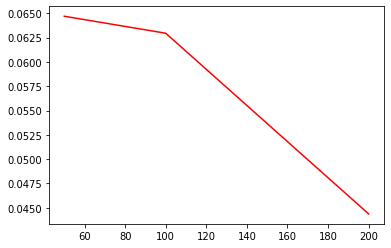

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(f_values, f_maprec_values, 'r-')
plt.show()

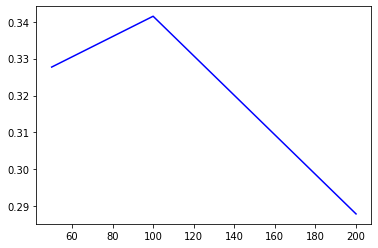

In [28]:
plt.plot(f_values, f_ndcg_values, 'b-')
plt.show()

Variando el numero de iteraciones maximas,

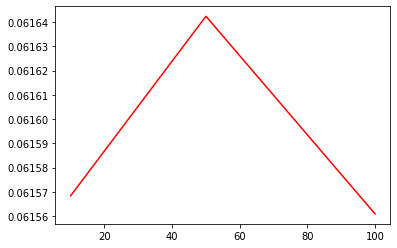

In [29]:
plt.plot(i_values, i_maprec_values, 'r-')
plt.show()

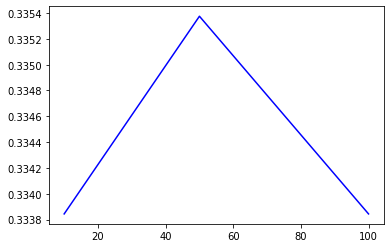

In [30]:
plt.plot(i_values, i_ndcg_values, 'b-')
plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

BPR, al igual que ALS, es un proceso de optimización iterativo que ocupa un modelo, función de pérdida o costo y aprendizaje. No obstante, BPR, a diferencia de ALS,  busca agregar el criterio de pareja usuario-item más que si un item es elegido por un usario o no. Esto lo realiza al utilizar tripletas usuario, item+ (interactuó) e item- (no interactuó) y para cada una se hace una actualización de los parámetros del modelo de entrenamiento.

In [19]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

  0%|          | 0/40 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [20]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257              Men in Black (1997)
244    Smilla's Sense of Snow (1997)
299                   Hoodlum (1997)
746               Real Genius (1985)
267                          unknown
332            Kiss the Girls (1997)
285            Secrets & Lies (1996)
331                 Edge, The (1997)
327                  Cop Land (1997)
300             Air Force One (1997)
Name: title, dtype: object

In [21]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                               Delicatessen (1991)
209                         This Is Spinal Tap (1984)
264                                      Mimic (1997)
143                        Sound of Music, The (1965)
194                                 Sting, The (1973)
27                                    Bad Boys (1995)
1448                        My Favorite Season (1993)
175                                     Brazil (1985)
201                               Evil Dead II (1987)
227     Star Trek VI: The Undiscovered Country (1991)
Name: title, dtype: object

In [22]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.04868596161173691
ndcg: 0.33690658499234305


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

Para n = 10

In [31]:
# FACTORES
f_values = [50, 100, 200]
f_maprec_values = [] # para almacenar resultados de MAE
f_ndcg_values = [] # para almacenar valores de RMSE

for v in f_values:  
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=v, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)  
  f_maprec_values.append(maprec)   
  f_ndcg_values.append(ndcg)

# ITERACIONES
i_values = [10, 50, 100]
i_maprec_values = [] # para almacenar resultados de MAE
i_ndcg_values = [] # para almacenar valores de RMSE

for v in f_values:  
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=100, iterations=v, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)  
  i_maprec_values.append(maprec)   
  i_ndcg_values.append(ndcg)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Variando el numero de factores,

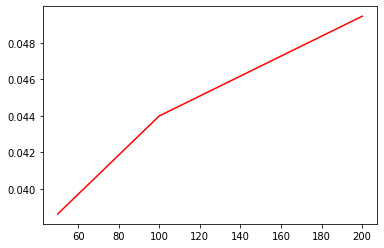

In [32]:
plt.plot(f_values, f_maprec_values, 'r-')
plt.show()

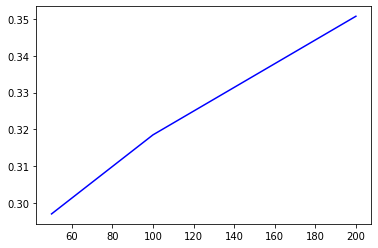

In [33]:
plt.plot(f_values, f_ndcg_values, 'b-')
plt.show()

Variando el numero de iteraciones maximas,

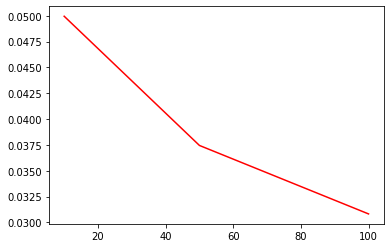

In [34]:
plt.plot(i_values, i_maprec_values, 'r-')
plt.show()

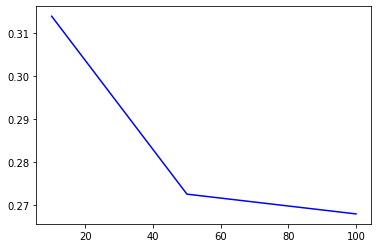

In [35]:
plt.plot(i_values, i_ndcg_values, 'b-')
plt.show()